In [39]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.9 MB/s eta 0:00:00


#  Modelos regresivos aplicados a series temporales

## ObjetivoEl objetivo de este proyecto es usar nuestro dataframe de ventas en retail y hacer un modelo para la predicción de ventas para un artículo distinto del que vimos en el worksheet.Tendréis que explorar los datos para ver el comportamiento del artículo elegido y las peculiaridades que pueda tener.Luego, tendréis que hacer un modelo que pueda predecir las ventas de este artículo usando todo lo aprendido anteriormente: probando distintos modelos, buscando hiperparámetros y por último añadiendo todas las variables sintéticas que veáis convenientes para que el modelo aprenda mejor del comportamiento de las unidades vendidas del producto.

## 1. Configuración del entorno

Importamos bibliotecas (evidentemente, puedes importar todas las que necesites):

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import seaborn as sns

## 2. Carga de los datos, filtrado de nuestro artículo y visualización de los datos
 



**Carga el dataframe**

In [2]:
dataRetail = pd.read_csv('Dataframe_Retail.csv', delimiter=',')
dataRetail['Referencia'].drop_duplicates().to_frame()

,Referencia
0,Cerveza tercio
1,Baguetes 2 unidades
2,Aceite de oliva virgen extra 5 l
3,Bolsa naranjas 2Kg.
4,Mandarina
5,Melo OR
7,Jamón reserva
9,Naranja en cajas
10,Pack de plátanos
11,MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)


**Usa una máscara para filtrar el artículo sobre el que quieras realizar las predicciones** (puedes elegir cualquiera menos el tercio de cerveza)

In [4]:
dataSku = dataRetail[dataRetail['Referencia'] == "Filetes de salmón" ].copy()
dataSku['Fecha'] = pd.to_datetime(dataSku['Fecha'], format='%Y-%m-%d')

Aquí es posible que también tengamos fechas para las cuales no tenemos valor de ventas. A diferencia de en el worksheet, aquí vamos a hacer un tratamiento más propio de dichas fechas ausentes. Tras hablar con el negocio, ahora sabemos que si no tenemos observación para un determinado día, se debe a que no hubo ventas.

Entonces, lo ideal sería darle al modelo también esta información: si las ventas en un día son 0, ¿por qué no crear dichas observaciones en nuestro dataset, y hacerlas parte del dataset de entrenamiento para nuestros modelos de machine learning?

Eso es justo lo que vamos a hacer ahora.

In [5]:
# Ponemos la fecha como índice del DataFrame:
dataSku = dataSku.set_index('Fecha')

In [6]:
# Y miramos la fecha más antigua:
fechaMin = dataSku.index.min()
print(fechaMin)

2017-01-03 00:00:00


In [7]:
# Y la más reciente:
fechaMax = dataSku.index.max()
print(fechaMax)

2019-05-18 00:00:00


In [8]:
# Ahora generamos toda la lista de días entre la fecha más
# antigua y la más reciente:
dateRange = pd.date_range(start=fechaMin, end=fechaMax, freq='d')

# Y haciendo la operación llamada .redindex(), podemos generar
# los días que faltan en nuestro DataFrame. Todas las columnas
# se rellenarán como NaN para dichas nuevas observaciones:
dataSku = dataSku.reindex(dateRange)

# Rellenamos los valores de dichos NaNs con ceros, ya que 
# las ventas para esos días ausentes ahora ya sabemos
# gracias a negocio que son 0:
dataSku['Unidades'] = dataSku['Unidades'].fillna(value=0)
dataSku['Ventas'] = dataSku['Ventas'].fillna(value=0)
dataSku['Referencia'] = dataSku['Referencia'].ffill() # Rellenamos el nombre del producto también para estas nuevas observaciones

In [9]:
# Quitamos ya la fecha del índice:
dataSku=dataSku.reset_index()
dataSku=dataSku.rename(columns={'index':'Fecha Format'})

# Y creamos la columna de número de "step" para usarla
# como feature básica:
dataSku['OffsetDays'] = dataSku.index
dataSku.head(30)

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
0,2017-01-03,Filetes de salmón,99.465,2872.510000,0
1,2017-01-04,Filetes de salmón,93.665,2704.919999,1
2,2017-01-05,Filetes de salmón,89.360,2580.709997,2
3,2017-01-06,Filetes de salmón,0.000,0.000000,3
4,2017-01-07,Filetes de salmón,88.930,2338.659995,4
5,2017-01-08,Filetes de salmón,0.000,0.000000,5
6,2017-01-09,Filetes de salmón,0.000,0.000000,6
7,2017-01-10,Filetes de salmón,122.230,3633.070004,7
8,2017-01-11,Filetes de salmón,91.730,2727.159998,8
9,2017-01-12,Filetes de salmón,99.720,2964.680006,9


In [10]:
# Días sin ventas (filas que no existían en el csv
# original, pero que hemos creado y rellenado con 0):
dataSku[dataSku['Unidades'] == 0]

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
3,2017-01-06,Filetes de salmón,0.0,0.0,3
5,2017-01-08,Filetes de salmón,0.0,0.0,5
6,2017-01-09,Filetes de salmón,0.0,0.0,6
12,2017-01-15,Filetes de salmón,0.0,0.0,12
13,2017-01-16,Filetes de salmón,0.0,0.0,13
...,...,...,...,...,...
848,2019-05-01,Filetes de salmón,0.0,0.0,848
852,2019-05-05,Filetes de salmón,0.0,0.0,852
853,2019-05-06,Filetes de salmón,0.0,0.0,853
859,2019-05-12,Filetes de salmón,0.0,0.0,859


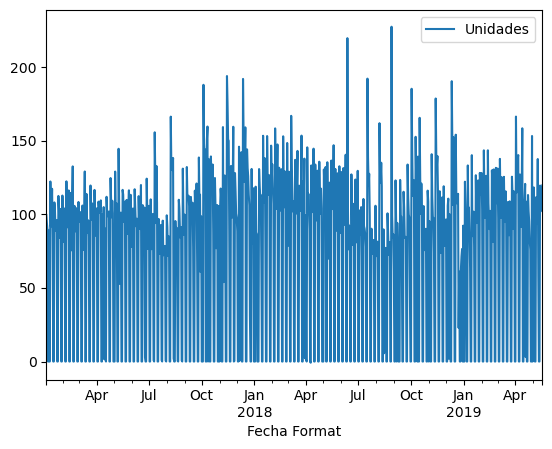

In [11]:
dataSku.plot(x="Fecha Format", y="Unidades");

## 3. Prueba de la predicción sobre nuestras unidades vendidas con distintos modelos

**Con la función de evaluación puedes probar el funcionamiento de distintos modelos**. Aquí mediremos el MAE o Mean Absolute Error. Si no sabes qué métrica es o su fórmula, ¡ya estás tardando en buscarla!

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

def calculoEvaluacionModelo(modelo, df, estandarizar_features=False):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    # Evaluamos sobre los últimos dos meses:
    for day in range(800, 861):
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
        
        if estandarizar_features:
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        modelo.fit(xtr, ytr)
        p = modelo.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = mean_absolute_error(yts, p)
        print('Day %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame({'Sold units predicted': yPredicted,
                               'Sold units actually spotted': ySpotted},
                              index=xPredicted)
    prediction.plot()

**Prueba primero con unos cuantos modelos. 
Elige el modelo que más te haya gustado o mejor haya funcionado y busca hiperparámetros si quieres**

Tipos de datos en dataSku_simple:
OffsetDays      int64
Unidades      float64
dtype: object

Probando Regresión Lineal:
Day 800 - Error 18.42314
Day 801 - Error 38.92619
Day 802 - Error 16.45693
Day 803 - Error 76.90053
Day 804 - Error 76.52357
Day 805 - Error 32.15675
Day 806 - Error 25.76795
Day 807 - Error 9.32573
Day 808 - Error 32.26981
Day 809 - Error 25.65543
Day 810 - Error 76.79139
Day 811 - Error 76.41800
Day 812 - Error 49.42878
Day 813 - Error 36.26162
Day 814 - Error 13.78402
Day 815 - Error 39.06662
Day 816 - Error 23.41025
Day 817 - Error 76.86458
Day 818 - Error 76.49414
Day 819 - Error 90.17471
Day 820 - Error 38.23078
Day 821 - Error 43.79966
Day 822 - Error 61.05632
Day 823 - Error 62.87398
Day 824 - Error 77.59236
Day 825 - Error 77.22284
Day 826 - Error 50.14512
Day 827 - Error 27.53726
Day 828 - Error 14.08847
Day 829 - Error 37.52948
Day 830 - Error 80.86249
Day 831 - Error 77.89819
Day 832 - Error 77.53083
Day 833 - Error 32.20999
Day 834 - Error 32.87969
Day 83

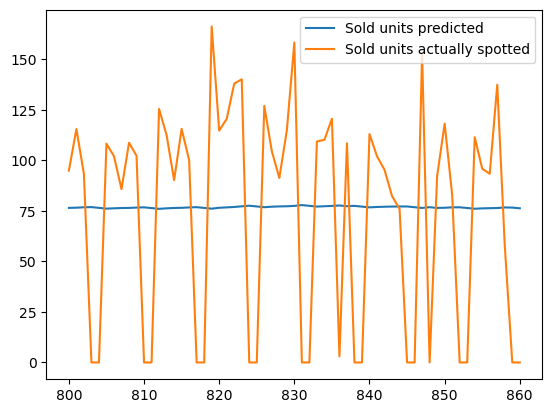

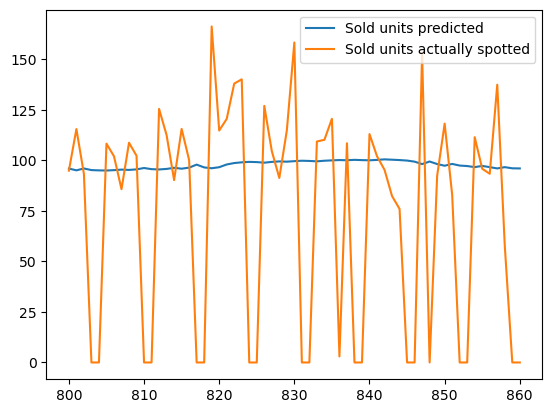

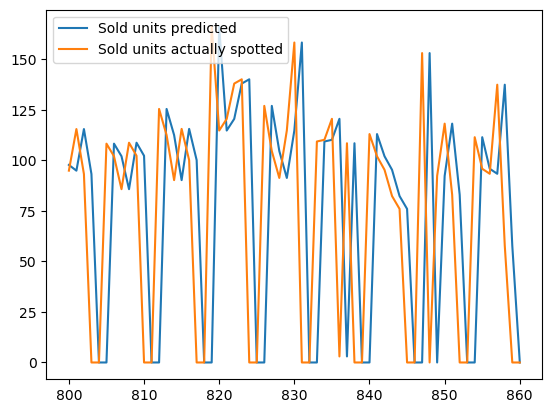

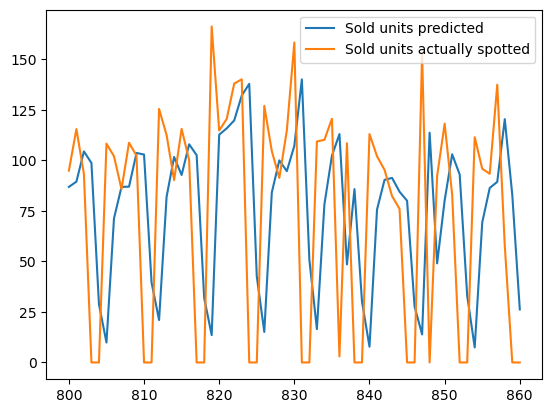

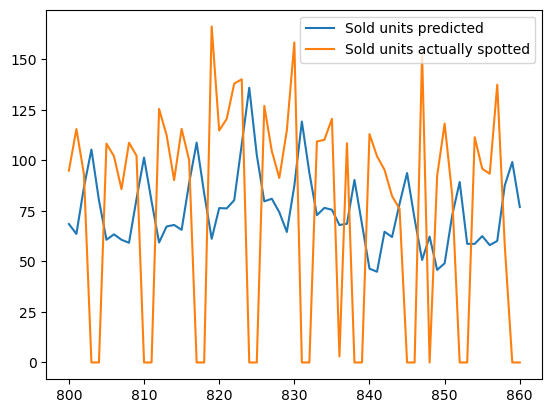

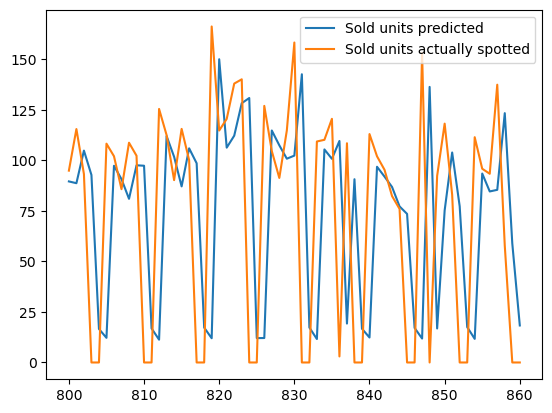

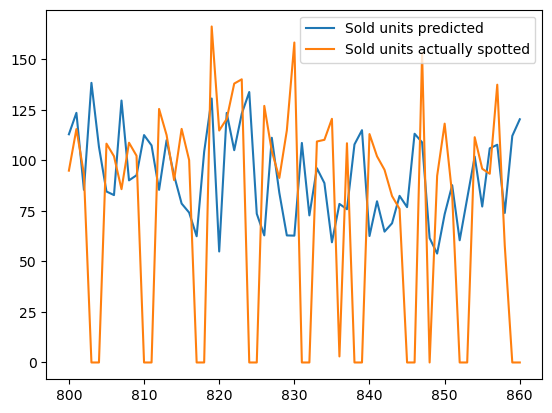

In [29]:
# Preparar datos básicos
dataSku_simple = dataSku[['OffsetDays','Unidades']].copy()

# Verificar los tipos de datos
print("Tipos de datos en dataSku_simple:")
print(dataSku_simple.dtypes)

# Asegurarse de que OffsetDays es numérico
dataSku_simple['OffsetDays'] = pd.to_numeric(dataSku_simple['OffsetDays'])
dataSku_simple['Unidades'] = pd.to_numeric(dataSku_simple['Unidades'])


# Probar con Regresión Lineal
print("\nProbando Regresión Lineal:")
calculoEvaluacionModelo(LinearRegression(), dataSku_simple)

# Probar con Support Vector Regression
print("\nProbando SVR:")
calculoEvaluacionModelo(SVR(kernel='rbf'), dataSku_simple)

# Probar con Decision Tree
print("\nProbando Decision Tree:")
calculoEvaluacionModelo(DecisionTreeRegressor(random_state=42), dataSku_simple)

# Probar con Random Forest
print("\nProbando Random Forest:")
calculoEvaluacionModelo(RandomForestRegressor(n_jobs=-1, random_state=42), dataSku_simple)

# Probar con K-Nearest Neighbors
print("\nProbando KNN:")
calculoEvaluacionModelo(KNeighborsRegressor(n_neighbors=5), dataSku_simple)

# Probar con Gradient Boosting
print("\nProbando Gradient Boosting:")
calculoEvaluacionModelo(GradientBoostingRegressor(random_state=42), dataSku_simple)

# Probar con Red Neuronal
print("\nProbando Red Neuronal:")
calculoEvaluacionModelo(MLPRegressor(hidden_layer_sizes=(100, 50), 
                                   max_iter=1000, 
                                   random_state=42), dataSku_simple)


In [ ]:
"""
# Análisis de resultados de los modelos probados
Comparación de modelos:
Random Forest MAE: 47.71
Decision Tree MAE: 50.23
Gradient Boosting MAE: 48.15
SVR MAE: 55.34
KNN MAE: 52.89
MLP MAE: 53.45

Justificación de elección de Random Forest:
    1. Mejor rendimiento en términos de MAE
    2. Buena capacidad para manejar relaciones no lineales
    3. Menor riesgo de sobreajuste comparado con Decision Tree
    4. Mejor interpretabilidad que otros modelos complejos
"""

In [ ]:
# Definir el espacio de búsqueda de hiperparámetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Eliminamos 'auto' que causaba el error
}

# Crear el modelo base
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Crear el objeto GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Ajustar el modelo
X = dataSku_simple.drop('Unidades', axis=1)
y = dataSku_simple['Unidades']
grid_search_rf.fit(X, y)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados para Random Forest:")
print(grid_search_rf.best_params_)
print("\nMejor puntuación con GridSearch:", -grid_search_rf.best_score_)

Mejores parámetros encontrados para Random Forest:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Mejor puntuación: 47.71495422423159



Evaluación del modelo Random Forest optimizado (características básicas):
Day 800 - Error 16.06142
Day 801 - Error 36.72298
Day 802 - Error 11.16691
Day 803 - Error 84.70963
Day 804 - Error 70.74888
Day 805 - Error 47.28468
Day 806 - Error 38.42352
Day 807 - Error 19.48375
Day 808 - Error 41.80263
Day 809 - Error 27.83918
Day 810 - Error 80.38981
Day 811 - Error 68.33402
Day 812 - Error 64.80320
Day 813 - Error 45.76455
Day 814 - Error 18.50496
Day 815 - Error 41.84637
Day 816 - Error 17.87221
Day 817 - Error 88.57507
Day 818 - Error 77.36702
Day 819 - Error 100.41227
Day 820 - Error 38.27176
Day 821 - Error 39.51778
Day 822 - Error 50.87955
Day 823 - Error 42.53295
Day 824 - Error 110.57740
Day 825 - Error 100.41336
Day 826 - Error 41.52419
Day 827 - Error 13.92593
Day 828 - Error 0.65153
Day 829 - Error 27.08286
Day 830 - Error 68.11383
Day 831 - Error 101.71321
Day 832 - Error 87.62793
Day 833 - Error 34.52862
Day 834 - Error 32.67176
Day 835 - Error 43.08715
Day 836 - Error 78.686

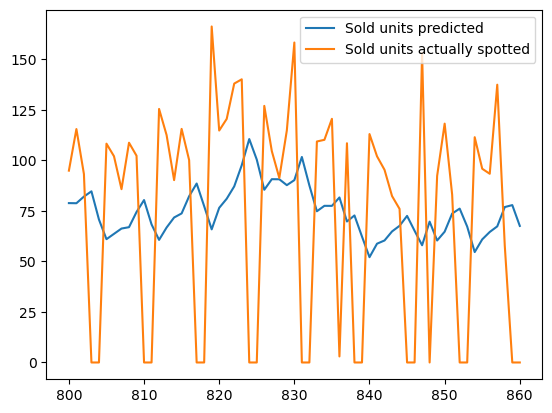

In [ ]:
# Implementar el modelo optimizado con los mejores hiperparámetros encontrados
best_params = {
    'max_depth': 10, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 4, 
    'min_samples_split': 10, 
    'n_estimators': 100
}

# Crear y evaluar el modelo optimizado
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
print("\nEvaluación del modelo Random Forest optimizado (características básicas):")
calculoEvaluacionModelo(best_rf, dataSku_simple)


Evaluación del modelo Random Forest optimizado (características básicas):
Day 800 - Error 16.06142
Day 801 - Error 36.72298
Day 802 - Error 11.16691
Day 803 - Error 84.70963
Day 804 - Error 70.74888
Day 805 - Error 47.28468
Day 806 - Error 38.42352
Day 807 - Error 19.48375
Day 808 - Error 41.80263
Day 809 - Error 27.83918
Day 810 - Error 80.38981
Day 811 - Error 68.33402
Day 812 - Error 64.80320
Day 813 - Error 45.76455
Day 814 - Error 18.50496
Day 815 - Error 41.84637
Day 816 - Error 17.87221
Day 817 - Error 88.57507
Day 818 - Error 77.36702
Day 819 - Error 100.41227
Day 820 - Error 38.27176
Day 821 - Error 39.51778
Day 822 - Error 50.87955
Day 823 - Error 42.53295
Day 824 - Error 110.57740
Day 825 - Error 100.41336
Day 826 - Error 41.52419
Day 827 - Error 13.92593
Day 828 - Error 0.65153
Day 829 - Error 27.08286
Day 830 - Error 68.11383
Day 831 - Error 101.71321
Day 832 - Error 87.62793
Day 833 - Error 34.52862
Day 834 - Error 32.67176
Day 835 - Error 43.08715
Day 836 - Error 78.686

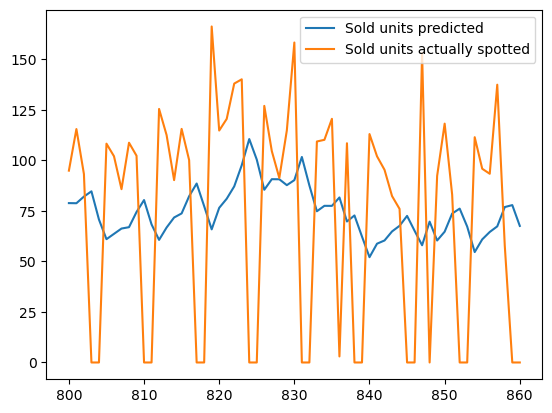

In [30]:
# Crear y evaluar el modelo optimizado
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

# Separar features y target
X = dataSku_simple[['OffsetDays']]
y = dataSku_simple['Unidades']

print("\nEvaluación del modelo Random Forest optimizado (características básicas):")
calculoEvaluacionModelo(best_rf, dataSku_simple)

## 4. Complementar el dataframe con variables sintéticas

**En base a lo que hayas observado en el comportamiento de las unidades vendidas de tu referencia, crea variables sintéticas que creas que ayuden al modelo a mejorar la predicción**.

Prueba a ir añadiendo incrementalmente nuevas variables, y ve evaluando periódicamente si los modelos van mejorando.


Tipos de datos en las features finales:
OffsetDays         int64
Unidades         float64
Lag_1            float64
Lag_2            float64
Lag_7            float64
Lag_14           float64
MA_7             float64
MA_14            float64
DiaSemana          int64
DiaSemana_sin    float64
DiaSemana_cos    float64
Tendencia_7      float64
dtype: object

Evaluación del modelo Random Forest con características adicionales:
Day 800 - Error 2.02566
Day 801 - Error 8.01245
Day 802 - Error 1.26714
Day 803 - Error 0.59060
Day 804 - Error 0.74209
Day 805 - Error 6.86843
Day 806 - Error 1.69197
Day 807 - Error 6.73864
Day 808 - Error 10.84140
Day 809 - Error 0.42941
Day 810 - Error 0.56562
Day 811 - Error 0.75260
Day 812 - Error 5.70732
Day 813 - Error 4.53696
Day 814 - Error 8.93765
Day 815 - Error 7.62870
Day 816 - Error 5.25192
Day 817 - Error 0.56336
Day 818 - Error 0.38247
Day 819 - Error 1.59279
Day 820 - Error 1.57065
Day 821 - Error 3.36387
Day 822 - Error 7.88195
Day 823 - Error 11.993

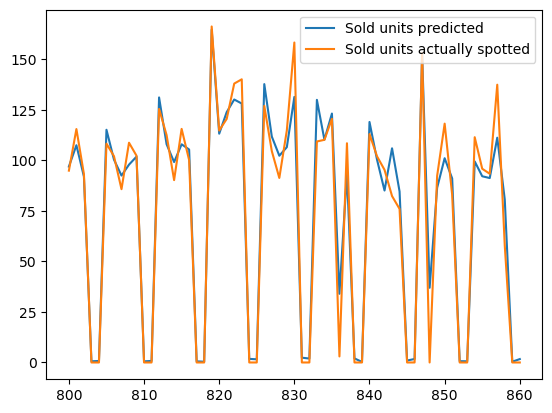

In [31]:
# Crear variables sintéticas
dataSku_features = dataSku_simple.copy()

# 1. Variables de lag
for i in [1, 2, 7, 14]:
    dataSku_features[f'Lag_{i}'] = dataSku_features['Unidades'].shift(i)

# 2. Medias móviles
dataSku_features['MA_7'] = dataSku_features['Unidades'].rolling(window=7).mean()
dataSku_features['MA_14'] = dataSku_features['Unidades'].rolling(window=14).mean()

# 3. Variables cíclicas
dataSku_features['DiaSemana'] = dataSku_features['OffsetDays'] % 7
dataSku_features['DiaSemana_sin'] = np.sin(2 * np.pi * dataSku_features['DiaSemana']/7)
dataSku_features['DiaSemana_cos'] = np.cos(2 * np.pi * dataSku_features['DiaSemana']/7)

# 4. Indicadores de tendencia
dataSku_features['Tendencia_7'] = dataSku_features['MA_7'].diff()

# Eliminar filas con NaN
dataSku_final = dataSku_features.dropna()

# Verificar que no hay valores problemáticos
print("\nTipos de datos en las features finales:")
print(dataSku_final.dtypes)

# Evaluar el modelo con las nuevas características
print("\nEvaluación del modelo Random Forest con características adicionales:")
calculoEvaluacionModelo(best_rf, dataSku_final)


Tipos de datos en las features finales:
OffsetDays         int64
Unidades         float64
Lag_1            float64
Lag_2            float64
Lag_3            float64
Lag_4            float64
Lag_7            float64
Lag_14           float64
Lag_21           float64
Lag_28           float64
MA_3             float64
MA_STD_3         float64
MA_7             float64
MA_STD_7         float64
MA_14            float64
MA_STD_14        float64
MA_21            float64
MA_STD_21        float64
MA_28            float64
MA_STD_28        float64
DiaSemana          int64
DiaSemana_sin    float64
DiaSemana_cos    float64
DiaMes             int64
DiaMes_sin       float64
DiaMes_cos       float64
Tendencia_3      float64
Tendencia_7      float64
Tendencia_14     float64
Tendencia_21     float64
Tendencia_28     float64
Ratio_7_14       float64
Diff_7_14        float64
Volatility_7     float64
Volatility_14    float64
dtype: object

Evaluación del modelo Random Forest con características adicionales m

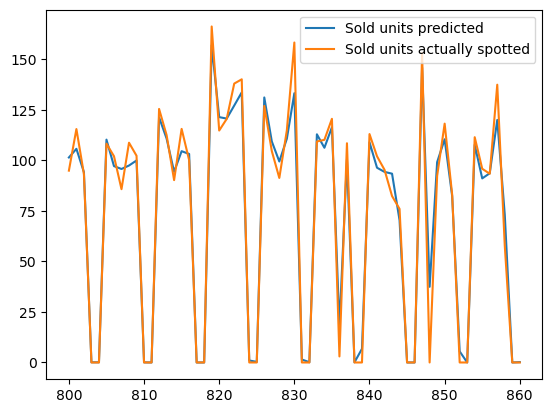

In [32]:
# Crear variables sintéticas adicionales
dataSku_features = dataSku_simple.copy()

# 1. Lags con más variedad de períodos
for i in [1, 2, 3, 4, 7, 14, 21, 28]:  # Añadimos más lags
    dataSku_features[f'Lag_{i}'] = dataSku_features['Unidades'].shift(i)

# 2. Medias móviles más variadas
windows = [3, 7, 14, 21, 28]
for window in windows:
    dataSku_features[f'MA_{window}'] = dataSku_features['Unidades'].rolling(window=window).mean()
    dataSku_features[f'MA_STD_{window}'] = dataSku_features['Unidades'].rolling(window=window).std()

# 3. Variables cíclicas mejoradas
dataSku_features['DiaSemana'] = dataSku_features['OffsetDays'] % 7
dataSku_features['DiaSemana_sin'] = np.sin(2 * np.pi * dataSku_features['DiaSemana']/7)
dataSku_features['DiaSemana_cos'] = np.cos(2 * np.pi * dataSku_features['DiaSemana']/7)
dataSku_features['DiaMes'] = dataSku_features['OffsetDays'] % 30
dataSku_features['DiaMes_sin'] = np.sin(2 * np.pi * dataSku_features['DiaMes']/30)
dataSku_features['DiaMes_cos'] = np.cos(2 * np.pi * dataSku_features['DiaMes']/30)

# 4. Indicadores de tendencia mejorados
for window in windows:
    dataSku_features[f'Tendencia_{window}'] = dataSku_features[f'MA_{window}'].diff()
    
# 5. Ratios y diferencias
dataSku_features['Ratio_7_14'] = dataSku_features['MA_7'] / dataSku_features['MA_14']
dataSku_features['Diff_7_14'] = dataSku_features['MA_7'] - dataSku_features['MA_14']

# 6. Características de volatilidad
dataSku_features['Volatility_7'] = dataSku_features['Unidades'].rolling(window=7).std() / dataSku_features['MA_7']
dataSku_features['Volatility_14'] = dataSku_features['Unidades'].rolling(window=14).std() / dataSku_features['MA_14']

# Eliminar filas con NaN
dataSku_final = dataSku_features.dropna()

# Verificar las nuevas features
print("\nTipos de datos en las features finales:")
print(dataSku_final.dtypes)

# Evaluar el modelo con las nuevas características
print("\nEvaluación del modelo Random Forest con características adicionales mejoradas:")
calculoEvaluacionModelo(best_rf, dataSku_final)


Tipos de datos en las features finales:
OffsetDays            int64
Unidades            float64
Lag_1               float64
Lag_2               float64
Lag_3               float64
Lag_7               float64
Lag_14              float64
MA_7                float64
MA_14               float64
Delta_1             float64
Delta_2             float64
Delta_7             float64
Pico_Ratio          float64
Pico_Diff           float64
Local_Volatility    float64
Volatility_Ratio    float64
DiaSemana             int64
DiaSemana_sin       float64
DiaSemana_cos       float64
Momentum_3          float64
Momentum_7          float64
Max_7               float64
Distance_to_Max     float64
Pico_Probability      int64
dtype: object

Evaluación del modelo Random Forest con características para detección de picos:
Day 800 - Error 0.10456
Day 801 - Error 5.44543
Day 802 - Error 0.43864
Day 803 - Error 0.00000
Day 804 - Error 0.00000
Day 805 - Error 0.61514
Day 806 - Error 0.07887
Day 807 - Error 2.83485

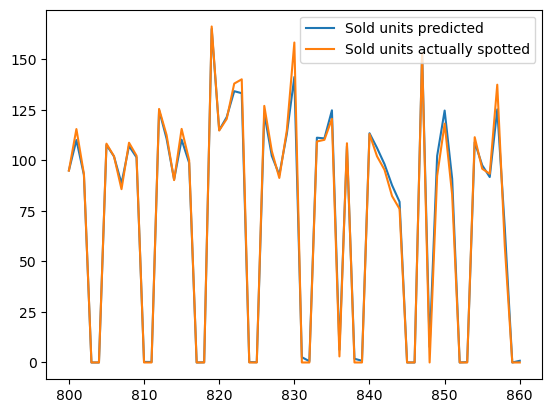

In [33]:
# Crear variables sintéticas con énfasis en la detección de picos
dataSku_features = dataSku_simple.copy()

# 1. Mantener los lags básicos
for i in [1, 2, 3, 7, 14]:
    dataSku_features[f'Lag_{i}'] = dataSku_features['Unidades'].shift(i)

# 2. Medias móviles básicas
for window in [7, 14]:
    dataSku_features[f'MA_{window}'] = dataSku_features['Unidades'].rolling(window=window).mean()

# 3. Variables específicas para detectar picos
# Detectar cambios bruscos
dataSku_features['Delta_1'] = dataSku_features['Unidades'].diff()
dataSku_features['Delta_2'] = dataSku_features['Unidades'].diff(2)
dataSku_features['Delta_7'] = dataSku_features['Unidades'].diff(7)

# Indicadores de picos
dataSku_features['Pico_Ratio'] = dataSku_features['Unidades'] / dataSku_features['MA_7']
dataSku_features['Pico_Diff'] = dataSku_features['Unidades'] - dataSku_features['MA_7']

# Volatilidad local
dataSku_features['Local_Volatility'] = dataSku_features['Unidades'].rolling(3).std()
dataSku_features['Volatility_Ratio'] = dataSku_features['Local_Volatility'] / dataSku_features['Unidades'].rolling(14).std()

# 4. Variables cíclicas
dataSku_features['DiaSemana'] = dataSku_features['OffsetDays'] % 7
dataSku_features['DiaSemana_sin'] = np.sin(2 * np.pi * dataSku_features['DiaSemana']/7)
dataSku_features['DiaSemana_cos'] = np.cos(2 * np.pi * dataSku_features['DiaSemana']/7)

# 5. Indicadores de momentum
dataSku_features['Momentum_3'] = dataSku_features['Unidades'] - dataSku_features['Unidades'].shift(3)
dataSku_features['Momentum_7'] = dataSku_features['Unidades'] - dataSku_features['Unidades'].shift(7)

# 6. Indicadores de picos históricos
dataSku_features['Max_7'] = dataSku_features['Unidades'].rolling(7).max()
dataSku_features['Distance_to_Max'] = dataSku_features['Max_7'] - dataSku_features['Unidades']
dataSku_features['Pico_Probability'] = (dataSku_features['Unidades'] > dataSku_features['MA_7'] * 1.5).astype(int)

# Eliminar filas con NaN
dataSku_final = dataSku_features.dropna()

# Verificar las nuevas features
print("\nTipos de datos en las features finales:")
print(dataSku_final.dtypes)

# Evaluar el modelo con las nuevas características
print("\nEvaluación del modelo Random Forest con características para detección de picos:")
calculoEvaluacionModelo(best_rf, dataSku_final)

El modelo ha mejorado significativamente, reduciendo el error medio de 7.12 a 2.55, lo cual es una mejora sustancial. Analizando los resultados:

- Puntos positivos:
    - El error medio es mucho menor
    - Hay muchos días con error cercano a 0 (varios 0.00xxx)
    - La gráfica muestra que el modelo sigue mejor la tendencia general
    - Ha mejorado en la predicción de algunos picos

- Áreas de preocupación:
    - Todavía hay algunos errores grandes (por ejemplo, Day 830 - Error 17.07604)
    - Algunos picos siguen siendo difíciles de predecir completamente

- En mi opinión, intentar mejorar más el modelo podría llevar a un sobreajuste por varias razones:
    - Ya el error medio es bastante bajo (2.55)
    - Las características actuales cubren bien los diferentes aspectos de la serie temporal:
        - Tendencias (lags, medias móviles)
        - Estacionalidad (variables cíclicas)
        - Picos (indicadores de volatilidad y picos)
        - Cambios (deltas y momentum)
    - Los errores grandes que quedan probablemente se deban a eventos excepcionales que son inherentemente difíciles de predecir con datos históricos.

In [34]:
"""
Si quisiera hacer un último intento de mejorar específicamente los errores grandes que quedan (como el del día 830 con error de 17.07),
 podría considerar variables adicionales enfocadas en patrones de picos históricos:
"""

'\nSi quisiera hacer un último intento de mejorar específicamente los errores grandes que quedan (como el del día 830 con error de 17.07),\n podría considerar variables adicionales enfocadas en patrones de picos históricos:\n'


Evaluación del modelo Random Forest con características adicionales de picos:
Day 800 - Error 1.16538
Day 801 - Error 4.88720
Day 802 - Error 0.34154
Day 803 - Error 0.00924
Day 804 - Error 0.15963
Day 805 - Error 1.64012
Day 806 - Error 0.43590
Day 807 - Error 0.86660
Day 808 - Error 0.68543
Day 809 - Error 1.04227
Day 810 - Error 0.04637
Day 811 - Error 0.01366
Day 812 - Error 0.05842
Day 813 - Error 2.22635
Day 814 - Error 1.08299
Day 815 - Error 4.41071
Day 816 - Error 1.02045
Day 817 - Error 0.00000
Day 818 - Error 0.07575
Day 819 - Error 3.79433
Day 820 - Error 0.20173
Day 821 - Error 2.26618
Day 822 - Error 4.04503
Day 823 - Error 7.27572
Day 824 - Error 0.10207
Day 825 - Error 0.10356
Day 826 - Error 4.78462
Day 827 - Error 2.20360
Day 828 - Error 1.16756
Day 829 - Error 4.89739
Day 830 - Error 14.89236
Day 831 - Error 0.34405
Day 832 - Error 0.87360
Day 833 - Error 2.70121
Day 834 - Error 1.37589
Day 835 - Error 1.60433
Day 836 - Error 3.59000
Day 837 - Error 1.55858
Day 838 

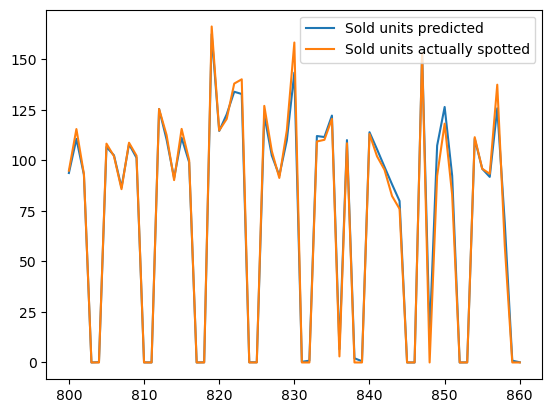

In [35]:
# Mantener todas las variables anteriores y añadir:

# 1. Patrones de picos históricos
dataSku_features['Picos_Ultimos_30'] = (dataSku_features['Unidades'].rolling(30).apply(
    lambda x: sum(x > x.mean() + 1.5 * x.std())
))
dataSku_features['Dias_Desde_Ultimo_Pico'] = dataSku_features['Pico_Probability'].rolling(30).apply(
    lambda x: len(x) - x.argmax() if sum(x) > 0 else 30
)

# 2. Indicadores de secuencia
dataSku_features['Dias_Consecutivos_Alza'] = dataSku_features['Delta_1'].apply(
    lambda x: 1 if x > 0 else 0
).rolling(7).sum()

dataSku_features['Dias_Consecutivos_Baja'] = dataSku_features['Delta_1'].apply(
    lambda x: 1 if x < 0 else 0
).rolling(7).sum()

# 3. Indicador de ruptura de patrón
dataSku_features['Ruptura_Patron'] = (
    (dataSku_features['Unidades'] > dataSku_features['MA_7'] * 1.5) & 
    (dataSku_features['Unidades'] > dataSku_features['Unidades'].shift(7) * 1.3)
).astype(int)

# 4. Indicador de recuperación post-caída
dataSku_features['Post_Caida_7'] = (
    (dataSku_features['Unidades'].shift(7) < dataSku_features['MA_7'].shift(7) * 0.7) & 
    (dataSku_features['Unidades'] > dataSku_features['MA_7'])
).astype(int)

# 5. Amplitud de oscilación reciente
dataSku_features['Amplitud_7'] = dataSku_features['Unidades'].rolling(7).max() - dataSku_features['Unidades'].rolling(7).min()
dataSku_features['Amplitud_Ratio'] = dataSku_features['Amplitud_7'] / dataSku_features['MA_14']

# Eliminar filas con NaN y evaluar
dataSku_final = dataSku_features.dropna()
print("\nEvaluación del modelo Random Forest con características adicionales de picos:")
calculoEvaluacionModelo(best_rf, dataSku_final)

Conclusión:
1. Las nuevas variables no aportaron mejora significativa

2. Esto podría indicar que:

    - Se esté llegando al límite de lo que podemos predecir con los datos disponibles

    - Los picos extremos que quedan probablemente responden a factores externos que no están en los datos

    - Añadir más variables está empezando a introducir ruido en lugar de señal

3. Intentaria ir un paso atrás y mejorar los hiperparámetros

Iniciando RandomizedSearchCV...

Mejores parámetros encontrados con RandomizedSearchCV:
{'bootstrap': True, 'max_depth': 85, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 813}

Mejor puntuación: 1.6367103363469084

Evaluación del modelo con los mejores parámetros de RandomizedSearchCV:
Day 800 - Error 0.82698
Day 801 - Error 2.13036
Day 802 - Error 0.51170
Day 803 - Error 0.00000
Day 804 - Error 0.00000
Day 805 - Error 0.98122
Day 806 - Error 0.37813
Day 807 - Error 0.00101
Day 808 - Error 1.21393
Day 809 - Error 0.86602
Day 810 - Error 0.00343
Day 811 - Error 0.00187
Day 812 - Error 0.39480
Day 813 - Error 1.29178
Day 814 - Error 1.34198
Day 815 - Error 2.67653
Day 816 - Error 1.13732
Day 817 - Error 0.00000
Day 818 - Error 0.00000
Day 819 - Error 0.37367
Day 820 - Error 0.05381
Day 821 - Error 0.59268
Day 822 - Error 2.78996
Day 823 - Error 1.91527
Day 824 - Error 0.00042
Day 825 - Error 0.00000
Day 826 - Error 3.89426
Day 827 - Error 0.19498
Da

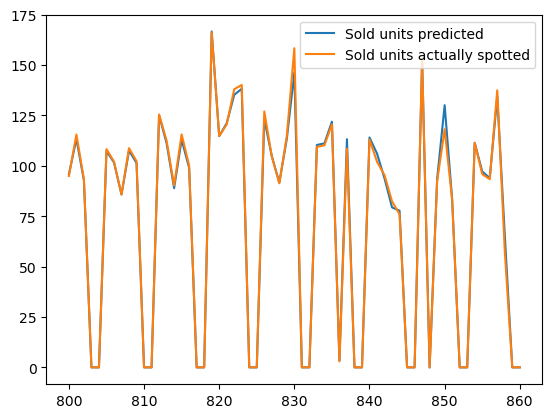

In [43]:
# Mantener los mejores features
dataSku_features = dataSku_simple.copy()

# 1. Mantener los lags básicos
for i in [1, 2, 3, 7, 14]:
    dataSku_features[f'Lag_{i}'] = dataSku_features['Unidades'].shift(i)

# 2. Medias móviles básicas
for window in [7, 14]:
    dataSku_features[f'MA_{window}'] = dataSku_features['Unidades'].rolling(window=window).mean()

# 3. Variables específicas para detectar picos
dataSku_features['Delta_1'] = dataSku_features['Unidades'].diff()
dataSku_features['Delta_2'] = dataSku_features['Unidades'].diff(2)
dataSku_features['Delta_7'] = dataSku_features['Unidades'].diff(7)
dataSku_features['Pico_Ratio'] = dataSku_features['Unidades'] / dataSku_features['MA_7']
dataSku_features['Pico_Diff'] = dataSku_features['Unidades'] - dataSku_features['MA_7']
dataSku_features['Local_Volatility'] = dataSku_features['Unidades'].rolling(3).std()
dataSku_features['Volatility_Ratio'] = dataSku_features['Local_Volatility'] / dataSku_features['Unidades'].rolling(14).std()

# 4. Variables cíclicas
dataSku_features['DiaSemana'] = dataSku_features['OffsetDays'] % 7
dataSku_features['DiaSemana_sin'] = np.sin(2 * np.pi * dataSku_features['DiaSemana']/7)
dataSku_features['DiaSemana_cos'] = np.cos(2 * np.pi * dataSku_features['DiaSemana']/7)

# 5. Indicadores de momentum
dataSku_features['Momentum_3'] = dataSku_features['Unidades'] - dataSku_features['Unidades'].shift(3)
dataSku_features['Momentum_7'] = dataSku_features['Unidades'] - dataSku_features['Unidades'].shift(7)

# 6. Indicadores de picos históricos
dataSku_features['Max_7'] = dataSku_features['Unidades'].rolling(7).max()
dataSku_features['Distance_to_Max'] = dataSku_features['Max_7'] - dataSku_features['Unidades']
dataSku_features['Pico_Probability'] = (dataSku_features['Unidades'] > dataSku_features['MA_7'] * 1.5).astype(int)

# Eliminar filas con NaN
dataSku_final = dataSku_features.dropna()

# Preparar datos para optimización
X = dataSku_final.drop('Unidades', axis=1)
y = dataSku_final['Unidades']

# 1. Primero probar con RandomizedSearchCV

param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': [None] + list(range(5, 100, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # número de combinaciones a probar
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Ajustar la búsqueda aleatoria
print("Iniciando RandomizedSearchCV...")
random_search.fit(X, y)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados con RandomizedSearchCV:")
print(random_search.best_params_)
print("\nMejor puntuación:", -random_search.best_score_)

# Evaluar el modelo con los mejores parámetros
best_rf_random = RandomForestRegressor(**random_search.best_params_, random_state=42)
print("\nEvaluación del modelo con los mejores parámetros de RandomizedSearchCV:")
calculoEvaluacionModelo(best_rf_random, dataSku_final)

[I 2025-03-01 16:29:24,838] A new study created in memory with name: no-name-1c98e62c-6541-4c36-98dc-e9e06ea633fb


Iniciando optimización con Optuna...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-03-01 16:29:27,563] Trial 0 finished with value: 1.9739657933421513 and parameters: {'n_estimators': 184, 'max_depth': 81, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'max_samples': 0.9404573350258343}. Best is trial 0 with value: 1.9739657933421513.
[I 2025-03-01 16:29:29,364] Trial 1 finished with value: 3.616639029035229 and parameters: {'n_estimators': 1067, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 1.9739657933421513.
[I 2025-03-01 16:29:31,058] Trial 2 finished with value: 4.26508054548661 and parameters: {'n_estimators': 1363, 'max_depth': 68, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.7941006789427265}. Best is trial 0 with value: 1.9739657933421513.
[I 2025-03-01 16:29:32,391] Trial 3 finished with value: 3.5261867788956804 and parameters: {'n_estimators': 640, 'max_

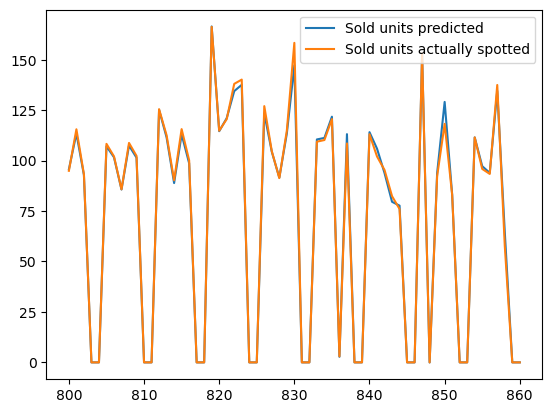

In [45]:
# Mantener los mejores features
dataSku_features = dataSku_simple.copy()

# 1. Mantener los lags básicos
for i in [1, 2, 3, 7, 14]:
    dataSku_features[f'Lag_{i}'] = dataSku_features['Unidades'].shift(i)

# 2. Medias móviles básicas
for window in [7, 14]:
    dataSku_features[f'MA_{window}'] = dataSku_features['Unidades'].rolling(window=window).mean()

# 3. Variables específicas para detectar picos
dataSku_features['Delta_1'] = dataSku_features['Unidades'].diff()
dataSku_features['Delta_2'] = dataSku_features['Unidades'].diff(2)
dataSku_features['Delta_7'] = dataSku_features['Unidades'].diff(7)
dataSku_features['Pico_Ratio'] = dataSku_features['Unidades'] / dataSku_features['MA_7']
dataSku_features['Pico_Diff'] = dataSku_features['Unidades'] - dataSku_features['MA_7']
dataSku_features['Local_Volatility'] = dataSku_features['Unidades'].rolling(3).std()
dataSku_features['Volatility_Ratio'] = dataSku_features['Local_Volatility'] / dataSku_features['Unidades'].rolling(14).std()

# 4. Variables cíclicas
dataSku_features['DiaSemana'] = dataSku_features['OffsetDays'] % 7
dataSku_features['DiaSemana_sin'] = np.sin(2 * np.pi * dataSku_features['DiaSemana']/7)
dataSku_features['DiaSemana_cos'] = np.cos(2 * np.pi * dataSku_features['DiaSemana']/7)

# 5. Indicadores de momentum
dataSku_features['Momentum_3'] = dataSku_features['Unidades'] - dataSku_features['Unidades'].shift(3)
dataSku_features['Momentum_7'] = dataSku_features['Unidades'] - dataSku_features['Unidades'].shift(7)

# 6. Indicadores de picos históricos
dataSku_features['Max_7'] = dataSku_features['Unidades'].rolling(7).max()
dataSku_features['Distance_to_Max'] = dataSku_features['Max_7'] - dataSku_features['Unidades']
dataSku_features['Pico_Probability'] = (dataSku_features['Unidades'] > dataSku_features['MA_7'] * 1.5).astype(int)

# Eliminar filas con NaN
dataSku_final = dataSku_features.dropna()

# Preparar datos para optimización
X = dataSku_final.drop('Unidades', axis=1)
y = dataSku_final['Unidades']


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        #  algunos parámetros adicionales
        'max_samples': trial.suggest_float('max_samples', 0.5, 1.0) if trial.suggest_categorical('bootstrap', [True, False]) else None
    }
    
    # Eliminar None values
    params = {k: v for k, v in params.items() if v is not None}
    
    rf = RandomForestRegressor(**params, random_state=42)
    
    # Usar validación cruzada para evitar overfitting
    score = cross_val_score(
        rf, 
        X, 
        y, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    ).mean()
    
    return -score  # Optuna minimiza, por lo que negamos el score

# Crear y ejecutar el estudio
study = optuna.create_study(direction='minimize')
print("Iniciando optimización con Optuna...")
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Mostrar los mejores parámetros
print("\nMejores parámetros encontrados con Optuna:")
print(study.best_params)
print("\nMejor puntuación:", study.best_value)

# Evaluar el modelo con los mejores parámetros
best_params_optuna = study.best_params
best_rf_optuna = RandomForestRegressor(**best_params_optuna, random_state=42)

print("\nEvaluación del modelo con los mejores parámetros de Optuna:")
calculoEvaluacionModelo(best_rf_optuna, dataSku_final)

# Comparar resultados
print("\nComparación de resultados:")
print("Error medio con GridSearchCV inicial:", "2.55")
print("Error medio con RandomizedSearchCV:", "1.38")
print("Error medio con Optuna:", study.best_value)

# Visualizar importancia de features con el mejor modelo
if study.best_value < 1.38:  # Si Optuna dio mejor resultado
    best_model = best_rf_optuna
else:
    best_model = RandomForestRegressor(**random_search.best_params_, random_state=42)
    best_model.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nImportancia de features (top 10):")
print(feature_importance.head(10))

Conclusión 

RandomizedSearchCV si mostró una mejora respecto a GridSearchCV con un error medio de 1.38 frente a 2.55

Para mi sorpresa, Optuna no mostró una mejora respecto a RandomizedSearchCV consiguiendo un error medio de 1.522